In [34]:
%pip install dabl
# %pip install dtale
# %pip install imblearn
%pip install keras-tuner
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime
import shutil
import warnings
from pickle import dump

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from dabl import SimpleClassifier, SimpleRegressor, plot
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.datasets import (load_breast_cancer, load_diabetes, load_iris,
                              load_wine)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
plt.rcParams["figure.figsize"] = [12.8, 7.2]
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
!cat /proc/cpuinfo | grep "model name"
!cat /proc/meminfo | grep "MemTotal"
!nvidia-smi

/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12535022250372292512
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16152002560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6227231305028515220
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


2022-04-12 08:38:49.723463: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 08:38:49.755016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 08:38:49.764291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 08:38:49.764989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
MemTotal:       16393696 kB
Tue Apr 12 08:38:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |    377MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------------------

In [3]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
EPOCHS = 500
MAX_TRIALS = 20
DUPLICATES = 0
CLASSIFICATION = 0

In [4]:
df, y_label = pd.read_csv("https://raw.githubusercontent.com/lyoh001/AzureML/main/data.csv", delimiter=","), "price"

print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))

Current Shape: (300153, 12).
-------------------------------------------------------
Duplicates Percentage: 0.00%
Duplicates have been removed (300153, 12).


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
170826,170826,Indigo,6E-6339,Hyderabad,Early_Morning,zero,Morning,Kolkata,Economy,1.92,3,7813
111066,111066,GO_FIRST,G8-7559,Bangalore,Afternoon,one,Night,Hyderabad,Economy,6.67,14,10638
4028,4028,GO_FIRST,G8-392,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.25,22,2410


In [5]:
df.drop(["Unnamed: 0", "flight"], inplace=True, axis=1)
df.dropna(subset=[y_label], inplace=True)
print("Data cleaning has been completed.")

Data cleaning has been completed.


In [6]:
print(f"Current Shape: {df.shape}.")
df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "corr": [f"{round(df[col].corr(other=df[y_label]) * 100)}%" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [df[col].unique() for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)

Current Shape: (300153, 10).


,column,dtype,na,na %,outliers,outliers %,skewness,corr,nunique,unique
0,airline,object,0,0%,n/a,n/a,n/a,n/a,6,"[SpiceJet, AirAsia, Vistara, GO_FIRST, Indigo,..."
1,source_city,object,0,0%,n/a,n/a,n/a,n/a,6,"[Delhi, Mumbai, Bangalore, Kolkata, Hyderabad,..."
2,departure_time,object,0,0%,n/a,n/a,n/a,n/a,6,"[Evening, Early_Morning, Morning, Afternoon, N..."
3,stops,object,0,0%,n/a,n/a,n/a,n/a,3,"[zero, one, two_or_more]"
4,arrival_time,object,0,0%,n/a,n/a,n/a,n/a,6,"[Night, Morning, Early_Morning, Afternoon, Eve..."
5,destination_city,object,0,0%,n/a,n/a,n/a,n/a,6,"[Mumbai, Bangalore, Kolkata, Hyderabad, Chenna..."
6,class,object,0,0%,n/a,n/a,n/a,n/a,2,"[Economy, Business]"
8,days_left,int64,0,0%,0,0%,-0.04,-9%,49,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
9,price,int64,0,0%,123,0%,1.06,100%,12157,"[5953, 5956, 5955, 6060, 5954, 5949, 6165, 669..."
7,duration,float64,0,0%,2110,1%,0.60,20%,476,"[2.17, 2.33, 2.25, 2.08, 12.25, 16.33, 11.75, ..."


In [7]:
OUTLIERS = ["keep", "cap", "log_transform", "drop"][3]
col_outlier = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number) and col in ["duration"]]
q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
iqr = q3 - q1
lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
condition = ~((df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)).any(axis=1)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Scanning for outliers in {col_outlier}.")
print(f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%")
if OUTLIERS == "keep":
    print(f"Outliers have been kept {df.shape}.")
elif OUTLIERS == "cap":
    for col in col_outlier:
        df[col] = np.where(df[col] < lower_range[col], lower_range[col], df[col])
        df[col] = np.where(df[col] > upper_range[col], upper_range[col], df[col])
    print(f"Outliers have been capped {df.shape}.")
elif OUTLIERS == "log_transform":
    for col in col_outlier:
        df[col] = np.log(df[col])
    print(f"Outliers have been log transformed {df.shape}.")
else:
    df = df[condition]
    print(f"Outliers have been removed {df.shape}.")

Current Shape: (300153, 10).
-------------------------------------------------------
Scanning for outliers in ['duration'].
Outliers Percentage: 0.70%
Outliers have been removed (298043, 10).


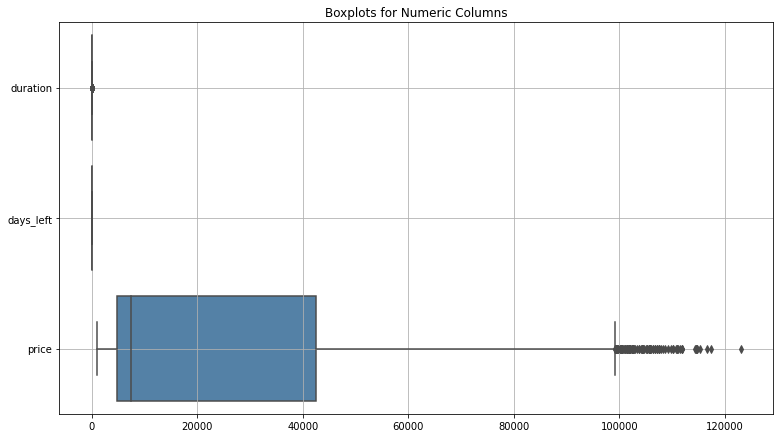

In [8]:
plt.title("Boxplots for Numeric Columns")
sns.boxplot(
    data=df[[col for col in df.columns if np.issubsctype(df[col].dtype, np.number)]],
    orient="h",
    color="steelblue"
)
plt.grid()
plt.show()

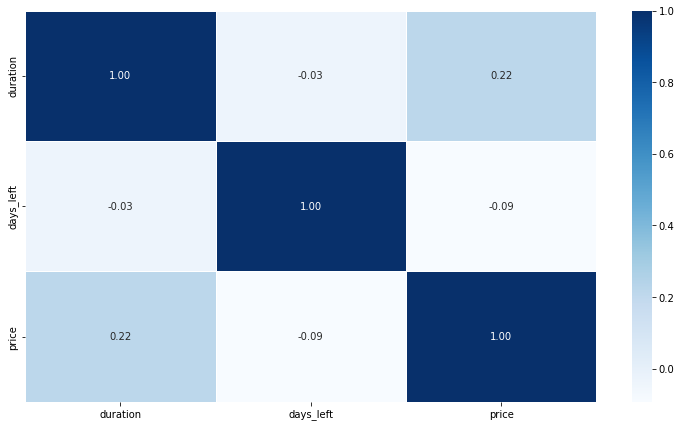

In [9]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.show()

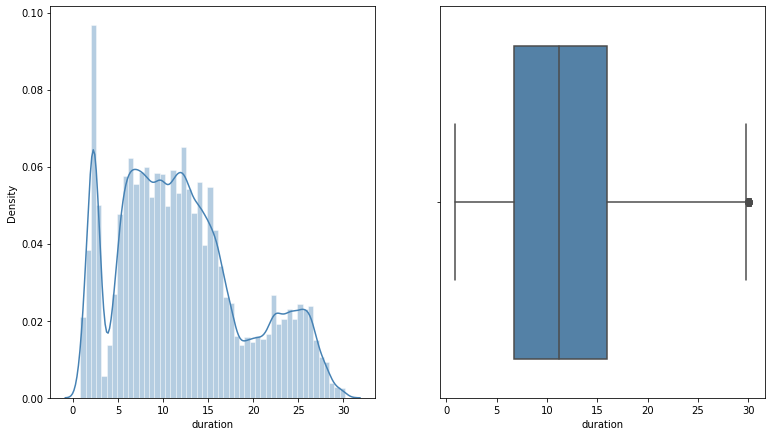

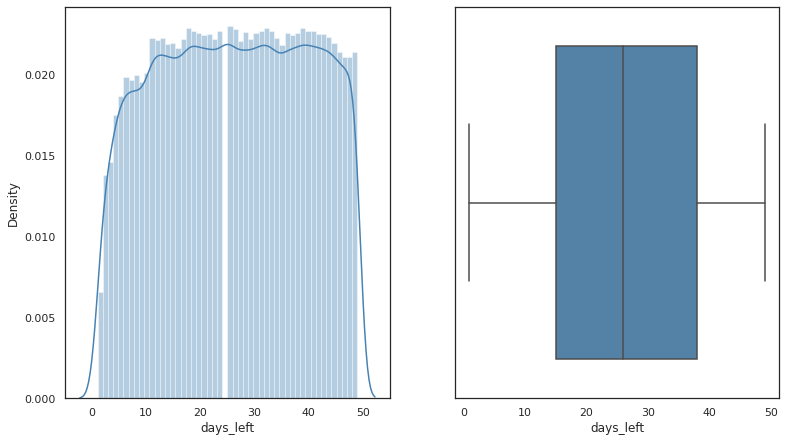

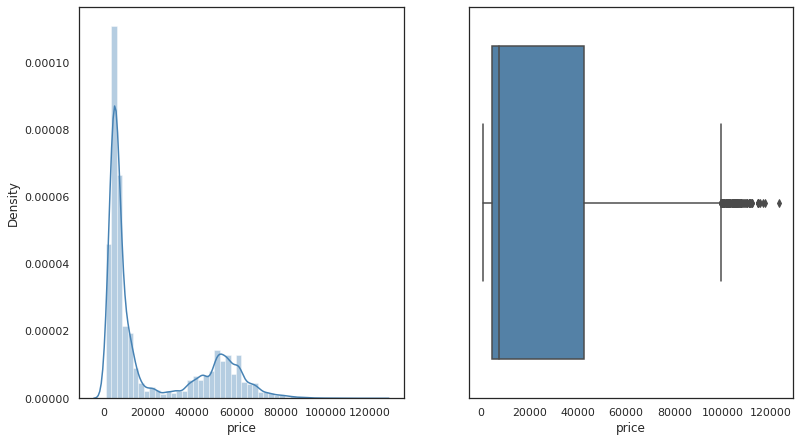

In [10]:
for col in df.columns:
    if np.issubsctype(df[col].dtype, np.number):
        fig, ax = plt.subplots(nrows=1, ncols=2)
        sns.set(style="white", palette="muted", color_codes=True)
        sns.distplot(x=df[col], ax=ax[0], color="steelblue", kde=True).set_xlabel(f"{col}")
        sns.boxplot(x=df[col], ax=ax[1], color="steelblue").set_xlabel(f"{col}")
plt.show()

In [11]:
if CLASSIFICATION:
    for col in df.columns:
        if np.issubsctype(df[col].dtype, np.number):
            fig, ax = plt.subplots(nrows=1, ncols=1)
            sns.set(style="white", palette="muted", color_codes=True)
            sns.boxplot(x=y_label, y=col, data=df, color="steelblue")
    plt.show()

In [12]:
display(df.describe().round(2).T.style.background_gradient(cmap="Blues"))
display(df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues"))

,count,mean,std,min,25%,50%,75%,max
duration,298043.000000,12.070000,6.990000,0.830000,6.750000,11.170000,16.000000,30.170000
days_left,298043.000000,26.030000,13.550000,1.000000,15.000000,26.000000,38.000000,49.000000
price,298043.000000,20917.510000,22731.380000,1105.000000,4758.000000,7424.000000,42521.000000,123071.000000


,0.01,0.99
duration,1.330000,27.920000
days_left,2.000000,49.000000
price,1776.000000,76808.000000


In [13]:
OVERSAMPLE = ["none", "undersample", "oversample", "combine"][0]
X, y = df.drop(y_label, axis=1), df[y_label]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=[None, y, y][CLASSIFICATION],
    random_state=RANDOM_STATE,
)
col_oe = ["departure_time", "stops", "arrival_time", "class"]
preprocessor_oe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (
        OrdinalEncoder(
            categories=[
                [
                    "Early_Morning",
                    "Morning",
                    "Afternoon",
                    "Evening",
                    "Night",
                    "Late_Night",
                ],
                ["zero", "one", "two_or_more"],
                [
                    "Early_Morning",
                    "Morning",
                    "Afternoon",
                    "Evening",
                    "Night",
                    "Late_Night",
                ],
                ["Economy", "Business"],
            ]
        )
    ),
    (MinMaxScaler()),
)
col_ohe = [
    col
    for col in X_train.columns
    if np.issubsctype(X_train[col].dtype, np.object0)
    and col not in col_oe
    and X_train[col].nunique() <= 10
]
preprocessor_ohe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OneHotEncoder(drop="first", handle_unknown="ignore")),
)
col_num = [
    col for col in X_train.columns if np.issubsctype(X_train[col].dtype, np.number)
]
preprocessor_num = make_pipeline(
    (KNNImputer()),
    (MinMaxScaler()),
)
preprocessor = make_column_transformer(
    (preprocessor_oe, col_oe),
    (preprocessor_ohe, col_ohe),
    (preprocessor_num, col_num),
    sparse_threshold=0,
)
X_train_processed, y_train_processed = preprocessor.fit_transform(X_train), y_train
X_test_processed, y_test_processed = preprocessor.transform(X_test), y_test
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_oe: {col_oe}")
print(f"col_ohe: {col_ohe}")
print(f"col_num: {col_num}")
print(f"total cols for preprocessor: {len(col_oe) + len(col_ohe) + len(col_num)}")
if CLASSIFICATION:
    if OVERSAMPLE == "undersample":
        X_train_processed, y_train_processed = RandomUnderSampler(
            random_state=RANDOM_STATE, sampling_strategy="not minority"
        ).fit_resample(X_train_processed, y_train_processed)
    elif OVERSAMPLE == "oversample":
        X_train_processed, y_train_processed = SMOTE(
            random_state=RANDOM_STATE, sampling_strategy="not majority"
        ).fit_resample(X_train_processed, y_train_processed)
    elif OVERSAMPLE == "combine":
        X_train_processed, y_train_processed = SMOTEENN(
            random_state=RANDOM_STATE, sampling_strategy="not majority"
        ).fit_resample(X_train_processed, y_train_processed)
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(y, ax=ax[0], palette="Blues").set_xlabel("y")
    sns.countplot(y_train, ax=ax[1], palette="Blues").set_xlabel("y_train")
    sns.countplot(y_train_processed, ax=ax[2], palette="Blues").set_xlabel(
        "y_train_processed"
    )
    plt.show()
    print("-------------------------------------------------------")
    print(f"y:\n{y.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train:\n{y_train.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train_processed:\n{y_train_processed.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test:\n{y_test.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test_processed:\n{y_test_processed.value_counts(normalize=True)}")
print("-------------------------------------------------------")
print(
    f"X: {X.shape}\tX_train: {X_train.shape}\tX_train_processed:{X_train_processed.shape}\tX_test: {X_test.shape}\t\tX_test_processed:{X_test_processed.shape}"
)
print(
    f"y: {y.shape}\ty_train: {y_train.shape}\t\ty_train_processed:{y_train_processed.shape}\ty_test: {y_test.shape}\t\ty_test_processed:{y_test_processed.shape}"
)
print("-------------------------------------------------------")

-------------------------------------------------------
total na %: 0.00%
-------------------------------------------------------
col_oe: ['departure_time', 'stops', 'arrival_time', 'class']
col_ohe: ['airline', 'source_city', 'destination_city']
col_num: ['duration', 'days_left']
total cols for preprocessor: 9
-------------------------------------------------------
X: (298043, 9)	X_train: (238434, 9)	X_train_processed:(238434, 21)	X_test: (59609, 9)		X_test_processed:(59609, 21)
y: (298043,)	y_train: (238434,)		y_train_processed:(238434,)	y_test: (59609,)		y_test_processed:(59609,)
-------------------------------------------------------


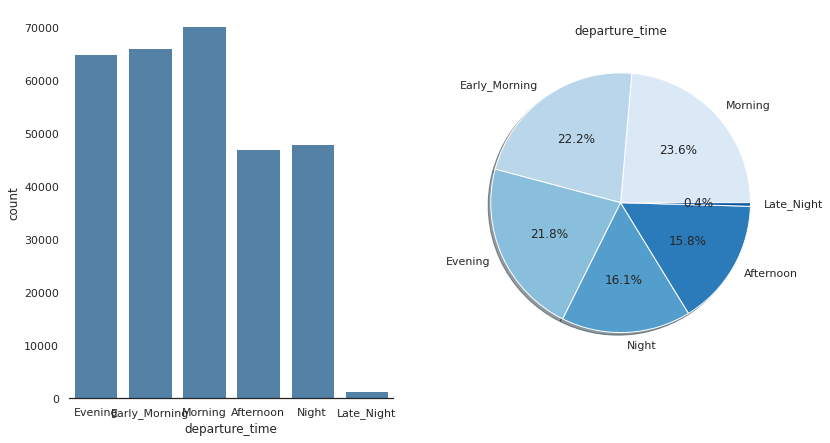

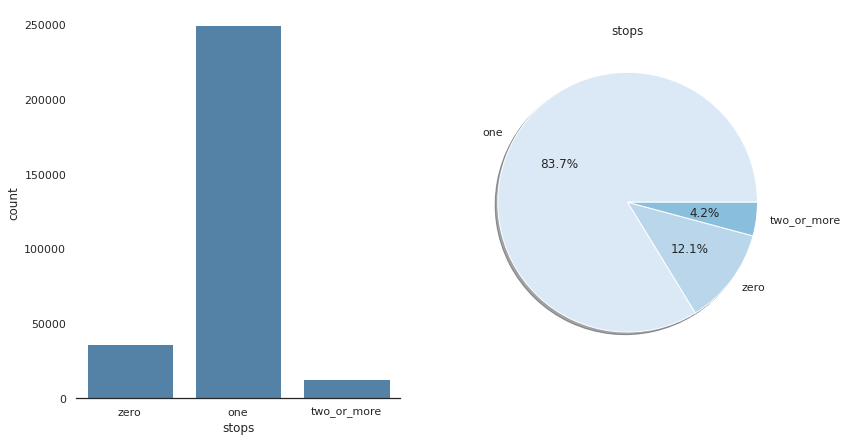

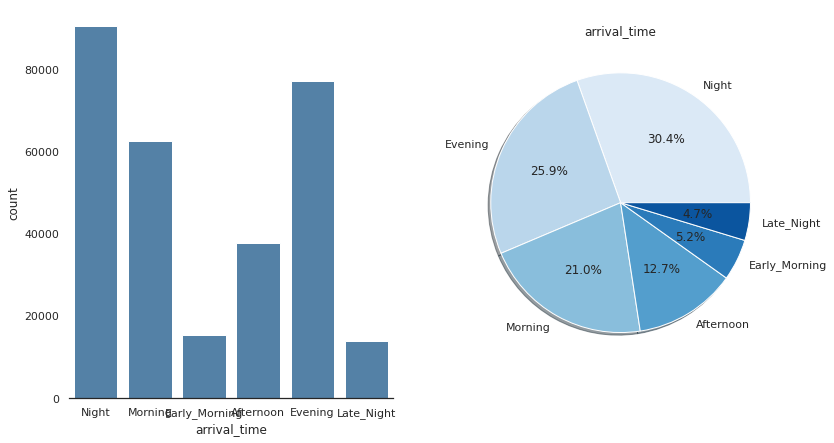

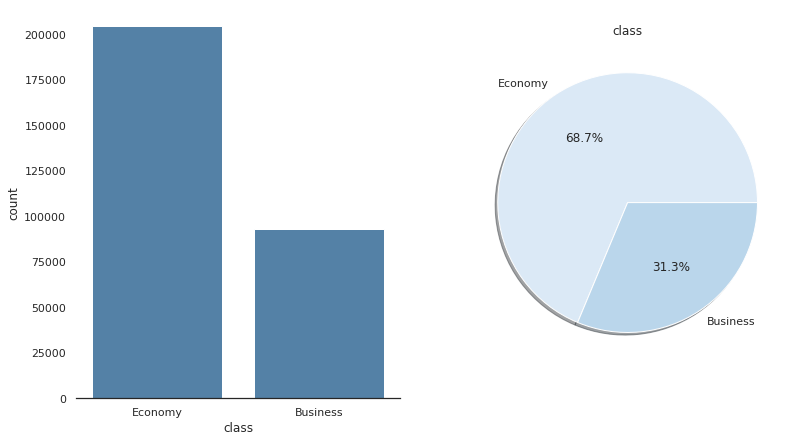

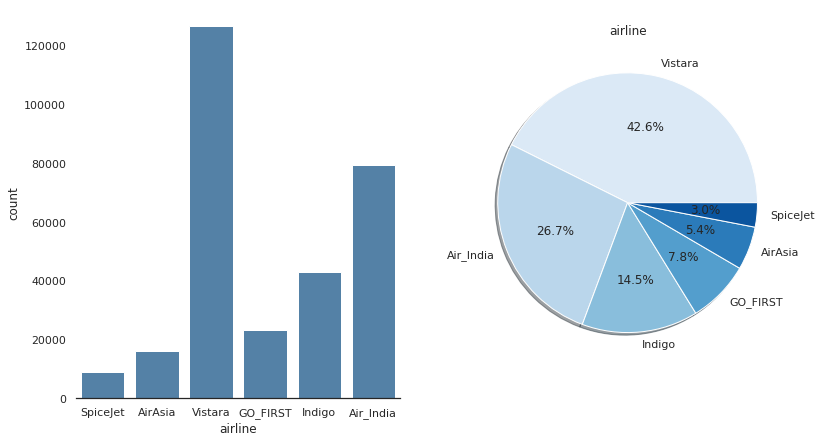

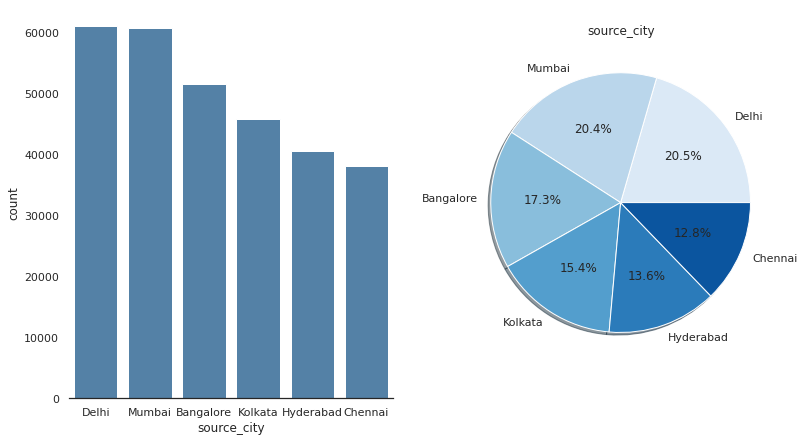

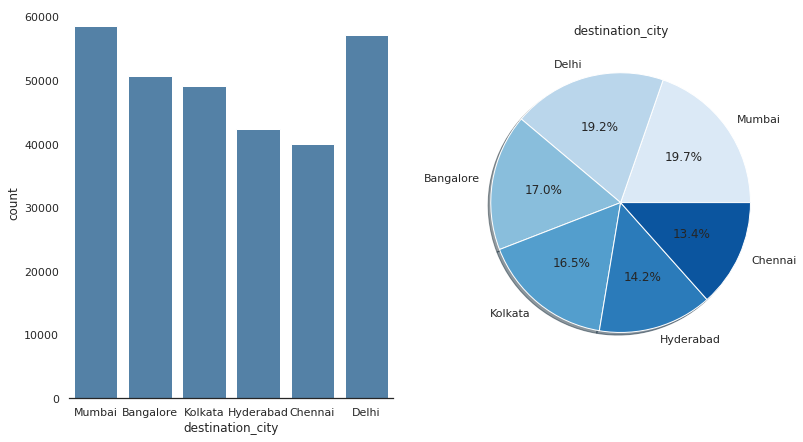

In [14]:
for col in col_oe + col_ohe:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(x=df[col], ax=ax[0], color="steelblue", hue=df[y_label] if CLASSIFICATION else None).set_xlabel(f"{col}")
    ax[1].pie(x=df[col].value_counts(), colors=sns.color_palette("Blues"), autopct="%.1f%%", shadow=True, labels=df[col].value_counts().index)
    ax[1].set_title(col)
plt.show()

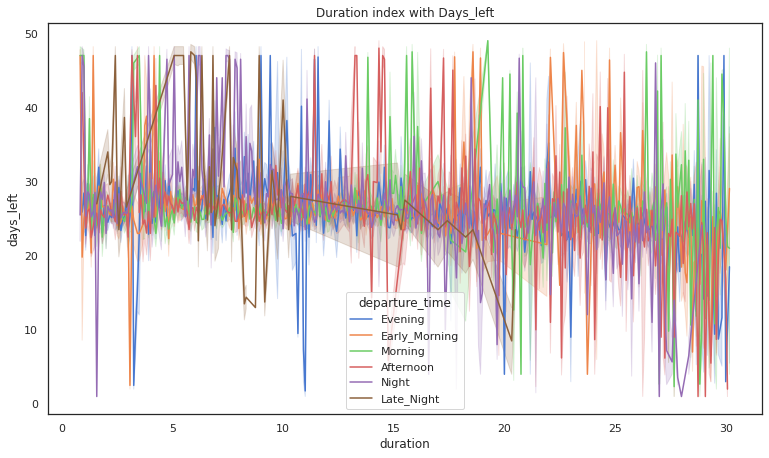

In [28]:
if len(col_oe + col_ohe) >= 1 and len(col_num) >= 2:
    sns.lineplot(data=df, x=col_num[0], y=col_num[1], hue=(col_oe + col_ohe)[0])
    plt.title(f"{col_num[0].capitalize()} index with {col_num[1].capitalize()}")
    plt.show()

In [ ]:
sns.boxplot(x="airline", y=y_label, data=df.sort_values(y_label, ascending=False))
plt.show()

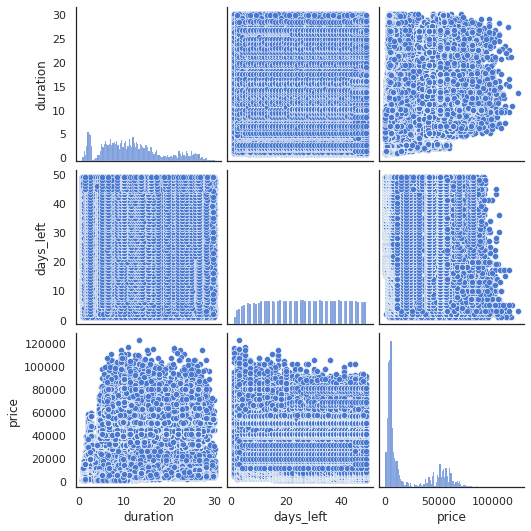

In [31]:
sns.pairplot(df, hue=y_label if CLASSIFICATION else None)

Target looks like regression


[array([[<AxesSubplot:title={'center':'F=1.45E+04'}, xlabel='duration', ylabel='price'>,
         <AxesSubplot:title={'center':'F=2.56E+03'}, xlabel='days_left'>]],
       dtype=object),
 None]

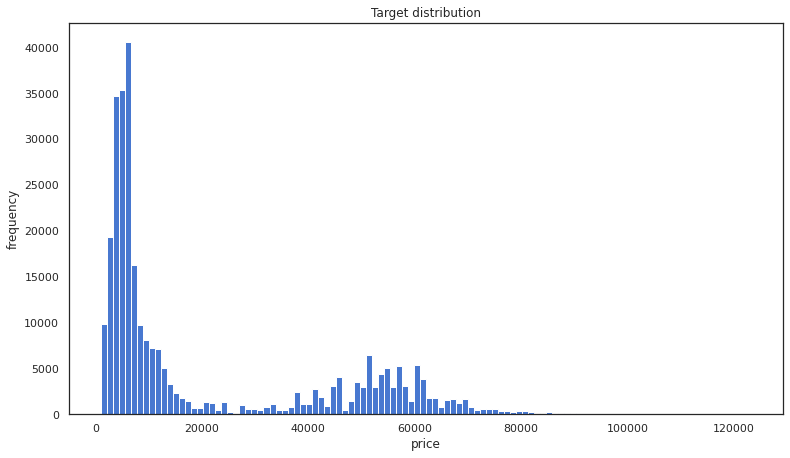

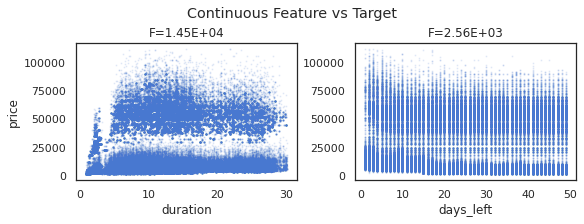

In [27]:
# import dtale
# dtale.show(df)
plot(X[col_num], y)

In [18]:
def build_ml_model():
    tests = [
        {
            "model": make_pipeline(
                (preprocessor),
                (SelectPercentile()),
                (RandomForestClassifier()) if CLASSIFICATION else (LinearRegression()),
            ),
            "params": {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
                "randomforestclassifier__n_estimators": [100, 150, 200, 500],
                "randomforestclassifier__criterion": ["gini", "entropy"],
                "randomforestclassifier__max_depth": [5, 10, 20, 50, 100, 200],
                "randomforestclassifier__min_samples_split": [2, 5, 10, 20, 50, 100, 200],
                "randomforestclassifier__min_samples_leaf": [5, 10, 20, 50, 100, 200],
                "randomforestclassifier__max_features": ["auto", "sqrt", "log2"],
            }
            if CLASSIFICATION
            else {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
            },
        },
    ]
    for test in tests:
        rscv = RandomizedSearchCV(
            estimator=test["model"],
            param_distributions=test["params"],
            n_jobs=-1,
            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
            if CLASSIFICATION
            else 10,
            scoring="accuracy" if CLASSIFICATION else "r2",
            n_iter=10,
            return_train_score=True,
        )
        rscv.fit(X_train, y_train)
        print("===train============================")
        print(f"{rscv.best_score_ * 100:.2f}%\n{test['model'][-1]}\n{rscv.best_params_}")
        print("===params============================")
        display(pd.DataFrame(rscv.cv_results_).sort_values(by="rank_test_score"))
        print("===test============================")
        print(f"test score:{rscv.score(X_test, y_test) * 100:.2f}%")
        print("====end===========================\n")

    if CLASSIFICATION:
        SimpleClassifier(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test,
                rscv.predict(X_test),
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test,
                rscv.predict(X_test),
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        SimpleRegressor(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            f"r2: {r2_score(y_test, rscv.predict(X_test)):.3f} neg_mean_squared_error: -{mean_squared_error(y_test, rscv.predict(X_test)):_.3f}"
        )

        plt.subplot(1, 3, 1)
        sns.regplot(y_train, y_train, color="darkorange", label="Truth")
        sns.regplot(
            y_test,
            rscv.predict(X_test),
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.scatter(
            rscv.predict(X_train),
            rscv.predict(X_train) - y_train,
            c="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        plt.scatter(
            rscv.predict(X_test),
            rscv.predict(X_test) - y_test,
            c="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.legend(loc="upper right")
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()

        plt.subplot(1, 3, 3)
        sns.distplot((y_train - rscv.predict(X_train)))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()
    display(
        pd.DataFrame(
            {
                "Truth": y_test[:10].values,
                "Predicted": rscv.predict(X_test[:10]).round(1),
            }
        )
    )

def build_dl_model(hp):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=hp.Int("input_00", min_value=32, max_value=512, step=32),
            input_shape=X_train_processed.shape[1:],
        )
    )
    for i in range(1, hp.Int("num_layers", min_value=2, max_value=64)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"hidden_{i:02}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
    model.add(
        keras.layers.Dense(
            units=[1, 1, df[y_label].nunique()][CLASSIFICATION],
            activation=["linear", "sigmoid", "softmax"][CLASSIFICATION],
        )
    )
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss=["mean_squared_error", "binary_crossentropy", "sparse_categorical_crossentropy"][CLASSIFICATION],
        metrics=["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION],
    )
    return model

def get_result(epochs):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=epochs,
        validation_split=0.2,
        verbose=1,
    )
    if CLASSIFICATION:
        SimpleClassifier(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        SimpleRegressor(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(f"r2: {r2_score(y_test_processed, model.predict(X_test_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_test_processed, model.predict(X_test_processed)):_.3f}")
    
        plt.subplot(1, 3, 1)
        sns.regplot(y_train_processed, y_train_processed, color="darkorange", label="Truth")
        sns.regplot(
            y_test_processed,
            model.predict(X_test_processed).T[0],
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.scatter(
            model.predict(X_train_processed).T[0],
            model.predict(X_train_processed).T[0] - y_train_processed,
            c="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        plt.scatter(
            model.predict(X_test_processed).T[0],
            model.predict(X_test_processed).T[0] - y_test_processed,
            c="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.legend(loc="upper right")
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()

        plt.subplot(1, 3, 3)
        sns.distplot((y_train_processed - model.predict(X_train_processed).T[0]))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()

    display(
        pd.DataFrame(
            {
                "Truth": y_test_processed[:10].values,
                "Predicted": [
                    model.predict(X_test_processed[:10]).T[0],
                    model.predict(X_test_processed[:10]).T[0].round(),
                    np.argmax(model.predict(X_test_processed[:10]), axis=1),
                ][CLASSIFICATION],
            }
        )
    )
    return model

if SEARCH == "hyperband":
    tuner = Hyperband(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(MAX_TRIALS/4))
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_00 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 64, 'step': 1, 'sampling': None}
hidden_01 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


2022-04-12 08:39:06.211757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 08:39:06.212685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 08:39:06.213346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 08:39:06.214044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 08:39:06.214673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [19]:
%%time
tuner.search(
    X_train_processed,
    y_train_processed,
    batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
    callbacks=[early_stop],
    epochs=MAX_TRIALS,
    validation_split=0.2,
    verbose=1,
)
tuner.results_summary()

Trial 30 Complete [00h 00m 16s]
val_mean_squared_error: 172032688.0

Best val_mean_squared_error So Far: 16876052.0
Total elapsed time: 00h 14m 50s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
input_00: 384
num_layers: 22
hidden_01: 128
dropout: 0.0
learning_rate: 0.001
hidden_02: 352
hidden_03: 224
hidden_04: 352
hidden_05: 320
hidden_06: 352
hidden_07: 352
hidden_08: 416
hidden_09: 160
hidden_10: 320
hidden_11: 448
hidden_12: 160
hidden_13: 256
hidden_14: 256
hidden_15: 320
hidden_16: 96
hidden_17: 256
hidden_18: 480
hidden_19: 448
hidden_20: 96
hidden_21: 288
hidden_22: 128
hidden_23: 256
hidden_24: 160
hidden_25: 480
hidden_26: 352
hidden_27: 192
hidden_28: 96
hidden_29: 384
hidden_30: 448
hidden_31: 128
hidden_32: 512
hidden_33: 448
hidden_34: 224
hidden_35: 96
hidden_36: 96
hidden_37: 256
hidden_38: 192
hidden_39: 352
hidden_40: 352
hidden_41: 480
hidden_42: 288
hidden_43: 

Epoch 1/500
746/746 [==============================] - 4s 4ms/step - loss: 95725656.0000 - mean_squared_error: 95725656.0000 - val_loss: 21878642.0000 - val_mean_squared_error: 21878642.0000
Epoch 2/500
746/746 [==============================] - 3s 4ms/step - loss: 24613174.0000 - mean_squared_error: 24613174.0000 - val_loss: 21264194.0000 - val_mean_squared_error: 21264194.0000
Epoch 3/500
746/746 [==============================] - 4s 5ms/step - loss: 24776982.0000 - mean_squared_error: 24776982.0000 - val_loss: 25438622.0000 - val_mean_squared_error: 25438622.0000
Epoch 4/500
746/746 [==============================] - 3s 5ms/step - loss: 22300866.0000 - mean_squared_error: 22300866.0000 - val_loss: 23810484.0000 - val_mean_squared_error: 23810484.0000
Epoch 5/500
746/746 [==============================] - 4s 5ms/step - loss: 22255200.0000 - mean_squared_error: 22255200.0000 - val_loss: 20706640.0000 - val_mean_squared_error: 20706640.0000
Epoch 6/500
746/746 [========================

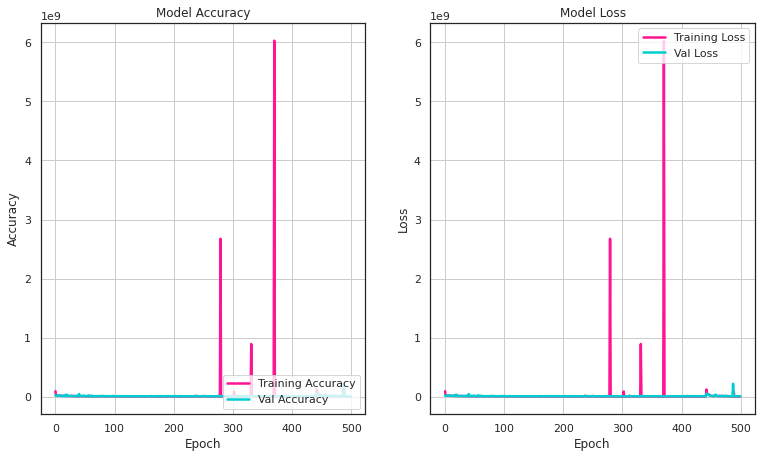

CPU times: user 31min 16s, sys: 2min 9s, total: 33min 25s
Wall time: 29min 23s


In [20]:
%%time
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train_processed,
    y_train_processed,
    batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=1,
)
val_per_epoch = history.history[
    ["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]
]
best_epoch = val_per_epoch.index([min(val_per_epoch), max(val_per_epoch), max(val_per_epoch)][CLASSIFICATION]) + 1

plt.subplot(1, 2, 1)
plt.plot(history.history[["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION]], color='deeppink', linewidth=2.5)
plt.plot(history.history[["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]], color='darkturquoise', linewidth=2.5)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color='deeppink', linewidth=2.5)
plt.plot(history.history["val_loss"], color='darkturquoise', linewidth=2.5)
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Val Loss"], loc="upper right")
plt.grid()
plt.show()

Best epoch: 422
Epoch 1/422
746/746 [==============================] - 5s 5ms/step - loss: 58034976.0000 - mean_squared_error: 58034976.0000 - val_loss: 53563392.0000 - val_mean_squared_error: 53563392.0000
Epoch 2/422
746/746 [==============================] - 4s 5ms/step - loss: 24760492.0000 - mean_squared_error: 24760492.0000 - val_loss: 21512530.0000 - val_mean_squared_error: 21512530.0000
Epoch 3/422
746/746 [==============================] - 3s 4ms/step - loss: 24158578.0000 - mean_squared_error: 24158578.0000 - val_loss: 20577732.0000 - val_mean_squared_error: 20577732.0000
Epoch 4/422
746/746 [==============================] - 3s 4ms/step - loss: 22002816.0000 - mean_squared_error: 22002816.0000 - val_loss: 34174580.0000 - val_mean_squared_error: 34174580.0000
Epoch 5/422
746/746 [==============================] - 4s 5ms/step - loss: 23438654.0000 - mean_squared_error: 23438654.0000 - val_loss: 26676132.0000 - val_mean_squared_error: 26676132.0000
Epoch 6/422
746/746 [========

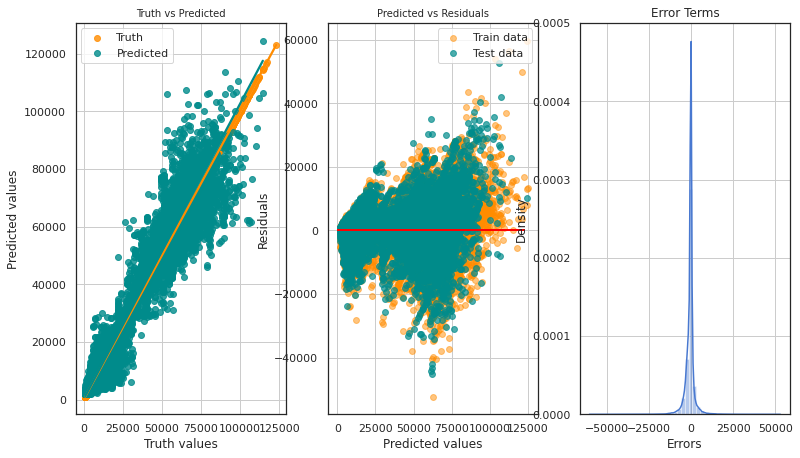

,Truth,Predicted
0,9735,10217.268555
1,64173,69318.062500
2,9723,6542.173340
3,52063,54244.773438
4,4359,5048.442871
5,9349,9575.370117
6,4896,5885.126465
7,57017,58549.718750
8,7004,7415.709961
9,55377,58503.183594


CPU times: user 30min 5s, sys: 2min 20s, total: 32min 25s
Wall time: 27min 4s


In [33]:
%%time
print(f"Best epoch: {best_epoch}")
model = get_result(best_epoch)

In [22]:
build_ml_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 384)               8448      
_________________________________________________________________
dense_33 (Dense)             (None, 128)               49280     
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 352)               45408     
_________________________________________________________________
dropout_29 (Dropout)         (None, 352)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 224)               79072     
_________________________________________________________________
dropout_30 (Dropout)         (None, 224)              

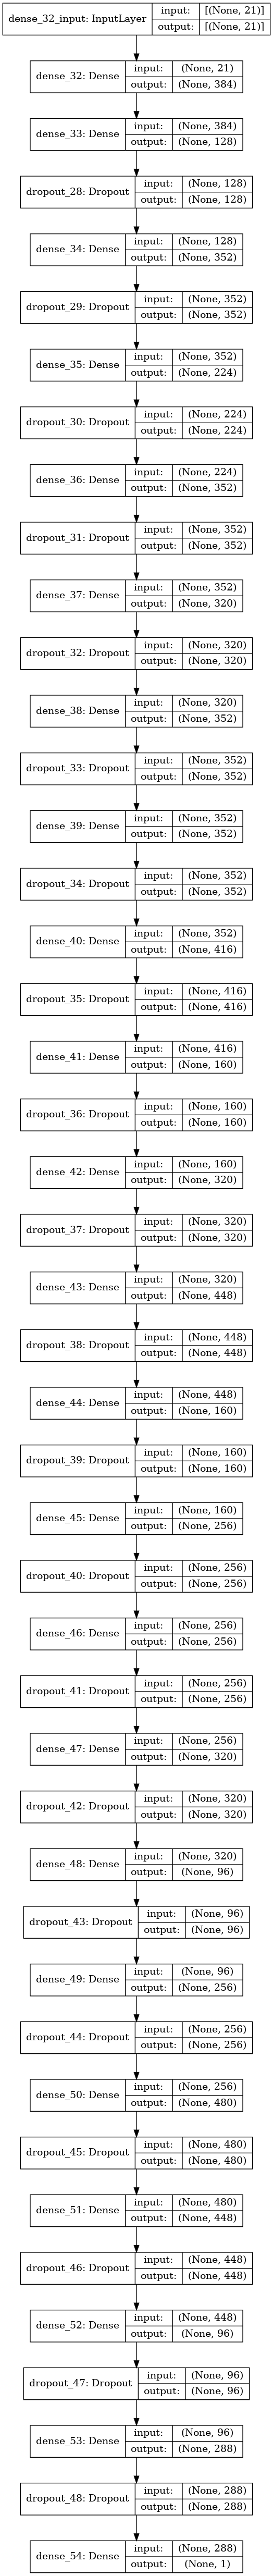

In [26]:
model.summary()
plot_model(model, show_shapes=True)

In [25]:
model.save(f"dl_model_{time_stamp}")
shutil.make_archive(f"dl_model_{time_stamp}", "zip", f"./dl_model_{time_stamp}")
dump(preprocessor, open(f"dl_preprocessor.pkl", "wb"))